# Concatenating a gridded rainfall dataset into a time series

:::{eval-rst}
:opticon:`tag`
:badge:`General,badge-primary`
:badge:`Preprocessing,badge-secondary`
:::

[![RoHub - FAIR Executable Research Object](https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue)](https://w3id.org/ro-id/1b8921af-e77f-4ccf-ae38-4813cdceba0f)

## Context
### Purpose
To load and extract a region of interest from a gridded rainfall dataset, and concatenate into a time series using the [Iris package](https://scitools-iris.readthedocs.io/en/stable/).

### Preprocessing description
Time series data allows us to carry out a wide range of analyses including but not limited to trend, seasonality, anomaly detection and causality. As most of the climatological datasets are gridded, we provide a general tool to preprocess them into time series. The example global dataset from NCEP/NCAR reanalysis has a fairly low resolution (T62 Gaussian grid or approximately 1.9 * 1.9 degrees lat/long) which allows easy execution. It is openly available with a variety of atmospheric variables at near surface levels in daily and monthly frequencies as well as long-term monthly mean in NetCDF format, which is described in and can be obtained from the [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html). 

This notebook uses a single sample data file for global daily precipitation rate (monthly mean) included with the notebook.

### Highlights
* Data for the entire globe is loaded and plotted using Iris
* Seasonal means are created by aggregating the data
* The Indonesian Borneo region is extracted and plotted
* The area-averaged time series for Indonesian Borneo region is created 
* A particular season and timeframe are extracted from the time series

### Contributions

#### Notebook
* Timothy Lam (author), University of Exeter, [@timo0thy](https://github.com/timo0thy)
* Marlene Kretschmer (author), University of Reading, [@MarleneKretschmer](https://github.com/MarleneKretschmer)
* Samantha Adams (author), Met Office Informatics Lab, [@svadams](https://github.com/svadams)
* Rachel Prudden (author), Met Office Informatics Lab, [@RPrudden](https://github.com/RPrudden)
* Elena Saggioro (author), University of Reading, [@ESaggioro](https://github.com/ESaggioro)
* Nick Homer (reviewer),  University of Edinburgh, [@NHomer](https://github.com/NHomer)

#### Dataset originator/creator
* NOAA National Center for Environmental Prediction (creator)

#### Dataset authors
* Eugenia Kalnay, Director, NCEP Environmental Modeling Center

#### Dataset documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "general-preprocessing-rainfall_noaa"
```

:::{note}
Note this data should be used only for non-commercial purposes.
:::

## Install and load libraries

In [1]:
import os
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat

import cf_units

import numpy as np
import matplotlib.pyplot as plt

import urllib.request

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

## Set project structure

In [2]:
notebook_folder = './general-preprocessing-rainfall_noaa'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Retrieve and/or load a sample data file

In [3]:
filepath = 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/surface_gauss/'
filename = 'prate.sfc.mon.mean.nc'

if not os.path.exists(notebook_folder+'/'+filename):
    urllib.request.urlretrieve(filepath+filename, os.path.join(notebook_folder, filename))

In [4]:
# Load monthly precipitation data into an iris cube
precip = iris.load_cube(os.path.join(notebook_folder, filename), 'Monthly Mean of Precipitation Rate')
precip.coord('latitude').guess_bounds()
precip.coord('longitude').guess_bounds()
print (precip)

Monthly Mean of Precipitation Rate / (unknown) (time: 893; latitude: 94; longitude: 192)
    Dimension coordinates:
        time                                        x              -              -
        latitude                                    -              x              -
        longitude                                   -              -              x
    Attributes:
        Conventions                            'COARDS'
        NCO                                    '20121013'
        References                             'http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.htm...
        actual_range                           array([-2.3283064e-10, 5.8903999e-04], dtype=float32)
        dataset                                'NCEP Reanalysis Derived Products'
        dataset_title                          'NCEP-NCAR Reanalysis 1'
        description                            'Data is from NMC initialized reanalysis\n(4x/day).  It consists of T42...
    

From print (precip) we have an idea whether the metadata is complete and where the possible gaps are. In case the iris cube does not contain a unit, we can set it as follows:

In [5]:
# Set unit of precipitation data, if the cube does not contain it
unit_to_add = 'kg m-2 s-1'
if precip.units == 'unknown':
    precip.units = cf_units.Unit (unit_to_add)

## Visualisation

Here we use the Iris wrapper to matplotlib pyplot to plot the gridded data with added coastline.

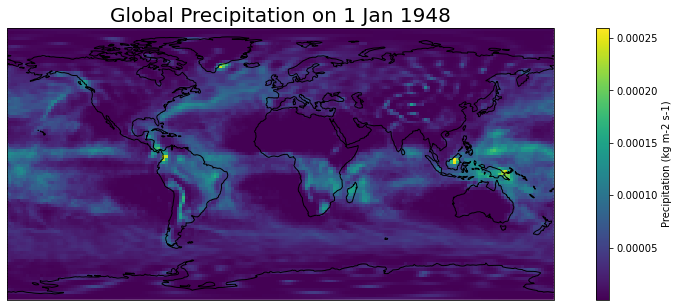

In [11]:
# Interactive plotting
plt.figure(figsize=(15, 5))
iplt.pcolormesh(precip[0]) # plot the first time in the cube
plt.title("Global Precipitation on 1 Jan 1948", fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Precipitation (' + str(precip.units) + ')')
plt.gca().coastlines()

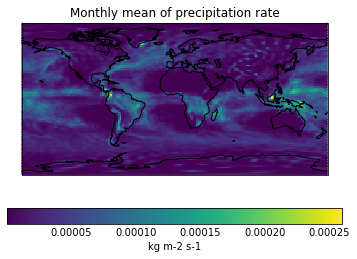

In [13]:
# Another way of plotting using iris.quickplot (with limited interactivity)
qplt.pcolormesh (precip[0])
plt.gca().coastlines()

## Create seasonal means

Here we construct seasonal means from the monthly data for each grid, for the purpose of extracting a particular season of interest later on.

In [14]:
# Add auxiliary coordinates to the cube to indicate each season
coord_cat.add_season(precip, 'time', name='clim_season')
coord_cat.add_season_year(precip, 'time', name='season_year')

In [15]:
print(precip)

Monthly Mean of Precipitation Rate / (kg m-2 s-1) (time: 893; latitude: 94; longitude: 192)
    Dimension coordinates:
        time                                           x              -              -
        latitude                                       -              x              -
        longitude                                      -              -              x
    Auxiliary coordinates:
        clim_season                                    x              -              -
        season_year                                    x              -              -
    Attributes:
        Conventions                               'COARDS'
        NCO                                       '20121013'
        References                                'http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.htm...
        actual_range                              array([-2.3283064e-10, 5.8903999e-04], dtype=float32)
        dataset                                   'NCEP

In [16]:
# Aggregate by season
annual_seasonal_mean = precip.aggregated_by(
    ['clim_season', 'season_year'],
    iris.analysis.MEAN)

In [17]:
# Check this worked
for season, year in zip(
    annual_seasonal_mean.coord('clim_season')[:10].points,
    annual_seasonal_mean.coord('season_year')[:10].points):
    print(season + ' ' + str(year))

djf 1948
mam 1948
jja 1948
son 1948
djf 1949
mam 1949
jja 1949
son 1949
djf 1950
mam 1950


## Extract Borneo region

Here we extract our area of study which covers the Indonesian Borneo region, as specified by Melendy et al. (2014) (available at https://daac.ornl.gov/CMS/guides/CMS_LiDAR_Indonesia.html). 

In [19]:
# Create a constraint for the latitude and Longitude extents

Borneo_lat = iris.Constraint(latitude=lambda v: v > -4.757 and v <= 3.211 )
Borneo_lon = iris.Constraint(longitude=lambda v: v > 107.815 and v <= 117.987 )

# Extract data based on the spatial extent
Borneo =  annual_seasonal_mean.extract(Borneo_lat & Borneo_lon) 
print(Borneo)

Monthly Mean of Precipitation Rate / (kg m-2 s-1) (time: 298; latitude: 4; longitude: 5)
    Dimension coordinates:
        time                                           x              -             -
        latitude                                       -              x             -
        longitude                                      -              -             x
    Auxiliary coordinates:
        clim_season                                    x              -             -
        season_year                                    x              -             -
    Cell methods:
        mean                                      clim_season, season_year
    Attributes:
        Conventions                               'COARDS'
        NCO                                       '20121013'
        References                                'http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.htm...
        actual_range                              array([-2.3283064e-10, 5

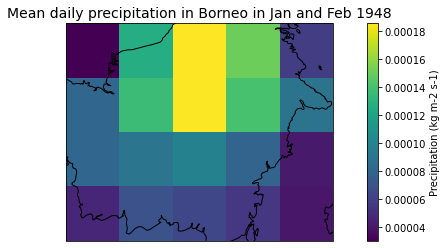

In [23]:
# Plot data of the first season in the study region
plt.figure(figsize=(12, 4))
iplt.pcolormesh(Borneo[0]) # plot the first timestep in the cube
plt.title("Mean daily precipitation in Borneo in Jan and Feb 1948", fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Precipitation (' + str(Borneo.units) + ')')
plt.gca().coastlines()

## Create area-averaged time series

To construct a seasonal rainfall time series for the study region, we first compute the areal average rainfall. Note that due to the spherical nature of the planet Earth, the area of every grid-box is not the same, therefore we need to perform the weighted mean based on the weights by area.

In [24]:
# Create area-weights array
grid_area_weights = iris.analysis.cartography.area_weights(Borneo)

# Perform the area-weighted mean using the computed grid-box areas.
Borneo_mean = Borneo.collapsed(['latitude', 'longitude'],
                                iris.analysis.MEAN,
                                weights=grid_area_weights)

We then extract the temporal timescale of interest (Boreal Summers from 1950 - 2019).

In [25]:
jja_constraint = iris.Constraint(clim_season='jja')
year_constraint = iris.Constraint(season_year=lambda v: v > 1949 and v <= 2019 )

Borneo_jja = Borneo_mean.extract(jja_constraint & year_constraint)
print(Borneo_jja)

Monthly Mean of Precipitation Rate / (kg m-2 s-1) (time: 70)
    Dimension coordinates:
        time                                           x
    Auxiliary coordinates:
        clim_season                                    x
        season_year                                    x
    Scalar coordinates:
        latitude                                  0.0 degrees, bound=(-3.80947, 3.80947) degrees
        longitude                                 114.375 degrees, bound=(109.6875, 119.0625) degrees
    Cell methods:
        mean                                      clim_season, season_year
        mean                                      latitude, longitude
    Attributes:
        Conventions                               'COARDS'
        NCO                                       '20121013'
        References                                'http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.htm...
        actual_range                              array([-2.3283064e

Finally, we use the Iris wrapper to matplotlib pyplot to plot the time series generated.

Text(0.5, 1.0, 'Borneo JJA Precipitation')

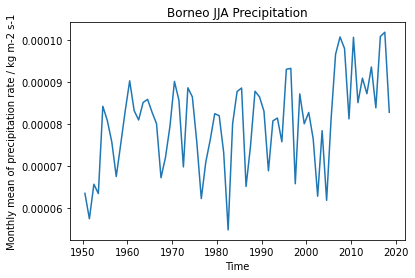

In [26]:
qplt.plot(Borneo_jja[-71:-1])
plt.title('Borneo JJA Precipitation')

### Save as a new NetCDF file

In [27]:
iris.save(Borneo_jja, os.path.join(notebook_folder, 'Borneo_precip_mean.nc'))

## Summary

This notebook has demonstrated the use of the Iris package to easily load, plot and manipulate gridded environmental NetCDF data.

## Citing this Notebook

Timothy Lam, Marlene Kretschmer, Samantha Adams, Rachel Prudden, Elena Saggioro, and Nick Homer. "Concatenating a gridded rainfall dataset into a time series (Jupyter Notebook) published in the Environmental Data Science book." ROHub.  XXX, XX,2022. Available at <link>.

## Additional information

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [28]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-06-17
